In [106]:
import numpy as np
import pandas as pd 

In [107]:
KAGGLE = False

In [108]:
if KAGGLE:
  SG1_PATH = '/kaggle/input/babe-media-bias-annotations-by-experts/data/final_labels_SG1.xlsx'
  SG2_PATH = '/kaggle/input/babe-media-bias-annotations-by-experts/data/final_labels_SG2.xlsx'
else:
  SG1_PATH = 'data/final_labels_SG1.xlsx'
  SG2_PATH = 'data/final_labels_SG2.xlsx'

df_sg1 = pd.read_excel(SG1_PATH)
df_sg2 = pd.read_excel(SG2_PATH)
df = pd.concat([df_sg1, df_sg2], ignore_index=True)

df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[]
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[]
2,Ingraham began the exchange by noting American...,https://www.breitbart.com/economy/2020/01/12/d...,breitbart,immigration,right,No agreement,No agreement,['flood']
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']"
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[]


In [109]:
df.isnull().sum()

text                0
news_link          60
outlet              0
topic               0
type             1000
label_bias          0
label_opinion       0
biased_words        0
dtype: int64

In [110]:
# Quitamos las filas que tienen un tipo nulo, ya que es vital para nuestro modelo. 
# Dejamos las filas con new_link nulo, ya que no necesitamos este valor.
df = df.dropna(subset=['type'])
df.isnull().sum()

text              0
news_link        58
outlet            0
topic             0
type              0
label_bias        0
label_opinion     0
biased_words      0
dtype: int64

In [111]:
df.shape

(4374, 8)

Definiremos helper functions para obtener el score de bias. El criterio de score es el siguiente:

Tomando left = -1, center = 0, right = 1, bias como 0 o 1 (dependiendo del valor en la columna 'label_bias'), y la cantidad de palabras en 'biased_words' como el score, calculamos el score de bias como valor de bias * position * cantidad.

In [112]:
# Returns the bias score for a given row
def score_bias(row):
    biased_word_count = count_biased_words(row['biased_words'])
    position = 1 if row['type'] == 'right' else 0 if row['type'] == 'center' else -1
    bias = row['label_bias']
    return bias * position * biased_word_count

# Count number of biased words in a column. 
# This expects a specific type of string.
# See the parsing function.
def count_biased_words(col):
    if isinstance(col, str):
        col = parse_string_array(col)
    return len(col)

# Parses the column with biased words.
# This columns is in the form of a string: "['word1', 'word2']",
# and not a list.
def parse_string_array(col):
    if col == '[]':
        return []
    res = []
    col = col.strip('"')
    col = col.lstrip('[')
    col = col.rstrip(']')
    for word in col.split(','):
        res.append(word.strip("'"))
    return res

In [113]:
# Only consider agreed upon labels
df = df[df['label_bias']!='No agreement']

In [114]:
# Encode label bias, now that we have only 2 categories: biased and unbiased.
df_encoded = pd.get_dummies(df, columns=['label_bias'], drop_first=True).rename(columns={'label_bias_Non-biased':'label_bias'})
df_encoded['label_bias'] = (~df_encoded['label_bias']).astype(int)
df_encoded.head()

,text,news_link,outlet,topic,type,label_opinion,biased_words,label_bias
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Expresses writer’s opinion,[],1
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Somewhat factual but also opinionated,[],0
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Somewhat factual but also opinionated,"['tragedy', 'stubborn']",1
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Entirely factual,[],0
5,A review of his posts in online message boards...,https://eu.usatoday.com/story/news/nation/2020...,usa-today,white-nationalism,center,Entirely factual,['plant'],1


In [115]:
df['Bias_Metric'] = df_encoded[['type', 'label_bias', 'biased_words']].apply(score_bias, axis=1)
df.head()

,text,news_link,outlet,topic,type,label_bias,label_opinion,biased_words,Bias_Metric
0,The Republican president assumed he was helpin...,http://www.msnbc.com/rachel-maddow-show/auto-i...,msnbc,environment,left,Biased,Expresses writer’s opinion,[],0
1,Though the indictment of a woman for her own p...,https://eu.usatoday.com/story/news/nation/2019...,usa-today,abortion,center,Non-biased,Somewhat factual but also opinionated,[],0
3,The tragedy of America’s 18 years in Afghanist...,http://feedproxy.google.com/~r/breitbart/~3/ER...,breitbart,international-politics-and-world-news,right,Biased,Somewhat factual but also opinionated,"['tragedy', 'stubborn']",2
4,The justices threw out a challenge from gun ri...,https://www.huffpost.com/entry/supreme-court-g...,msnbc,gun-control,left,Non-biased,Entirely factual,[],0
5,A review of his posts in online message boards...,https://eu.usatoday.com/story/news/nation/2020...,usa-today,white-nationalism,center,Biased,Entirely factual,['plant'],0


<Axes: >

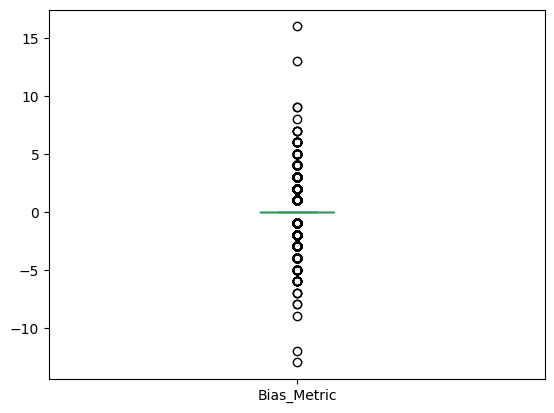

In [116]:
# Visualize the distribution of the bias metric
df['Bias_Metric'].plot.box()

In [117]:
# Remove 'center' articles with labeled as biased, since our score metric would score these as 0.
df = df[~((df["type"] == "center") & (df["label_bias"] == 1))]

In [ ]:
# Additional features for the model
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['char_count'] = df['text'].apply(lambda x: len(x))

In [ ]:
from scipy.stats import zscore

# Remove outliers
df[zscore(df['Bias_Metric']) > 4].shape
df_clean = df[zscore(df['Bias_Metric']) < 4]
df_clean.shape

(4210, 11)

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer

In [ ]:
X = df_clean[['text', 'outlet', 'topic', 'word_count', 'char_count']]
y = df_clean['Bias_Metric']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing phase, to transform text into numerical features and encode categorical features, was well as normalize numerical features
preprocessor = ColumnTransformer([
    ('text', TfidfVectorizer(max_features=5000), 'text'),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['outlet', 'topic']),
    ('num', StandardScaler(), ['word_count', 'char_count'])
])

# Pipeline for the model, first preprocessing the data, then define the model
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=10))
])
model.fit(X_train, y_train)
print("Train Score:", model.score(X_train, y_train))
print("Test Score:", model.score(X_test, y_test))

Train Score: 0.6743265775375515
Test Score: 0.4829932456088367


In [ ]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# A stacking regressor, combining Random Forest and Gradient Boosting models as base models
base_models = [
    ('f', Pipeline([('preprocessor', preprocessor), ('clf', RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10, min_samples_leaf=4, min_samples_split=10))])),
    ('s', Pipeline([('preprocessor', preprocessor), ('gbr', GradientBoostingRegressor(n_estimators=500, random_state=42))]))
]

# Define meta-model, a Ridge model
meta_model = Ridge()

stacking_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

stacking_reg.fit(X_train, y_train)
print("Stacking Regressor R² Score:", stacking_reg.score(X_test, y_test))

Stacking Regressor R² Score: 0.6205830117593674
